In [198]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.api import ARIMA

In [199]:
palette_tab10 = sns.color_palette("tab10", 10)
cmap = sns.color_palette([palette_tab10[0], palette_tab10[1]], as_cmap=True)
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

Read the data

In [200]:
DIR_SUBJECT_1 = '../udataset/meat/production.csv'
# DIR_SUBJECT_1 = '../udataset/meat/cold_storage.csv'
# DIR_SUBJECT_1 = '../udataset/meat/slaughter.csv'
# DIR_SUBJECT_1 = '../udataset/meat/weights.csv'
df_subject1 = pd.read_csv(DIR_SUBJECT_1)
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Other Chicken,Turkey,Red Meat,Poultry
0,2001-01,2.172000e+09,17000000.0,1.672000e+09,18000000.0,2.622200e+09,42700000.0,403400000.0,3.879000e+09,3.068300e+09
1,2001-02,1.852000e+09,15000000.0,1.467000e+09,17000000.0,2.322200e+09,39700000.0,461200000.0,3.351000e+09,2.823100e+09
2,2001-03,2.065000e+09,16000000.0,1.606000e+09,23000000.0,2.588600e+09,44400000.0,409300000.0,3.710000e+09,3.042300e+09
3,2001-04,1.910000e+09,15000000.0,1.514000e+09,19000000.0,2.515700e+09,42200000.0,462000000.0,3.458000e+09,3.019900e+09
4,2001-05,2.265000e+09,15000000.0,1.535000e+09,16000000.0,2.835600e+09,45600000.0,428800000.0,3.831000e+09,3.310000e+09
...,...,...,...,...,...,...,...,...,...,...
271,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,51100000.0,433500000.0,4.624900e+09,4.641300e+09
272,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,48400000.0,489200000.0,4.302200e+09,4.343100e+09
273,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,50600000.0,431200000.0,4.720800e+09,4.659100e+09
274,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,44500000.0,500300000.0,4.638900e+09,4.362100e+09


Make variables for specific dataset 1

In [201]:
# For meat production
df_subject1 = df_subject1.drop(columns=['Other Chicken'])
df_subject1 = df_subject1.dropna()
MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']
SUBJECT1 = 'meat_production'
UNIT = 'Pounds'

# For meat cold storage
# MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'frozen_egg', 'red_meat', 'poultry']

SUBJECT_TITLE1 = SUBJECT1.replace('_', ' ').title()
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Turkey,Red Meat,Poultry
0,2001-01,2.172000e+09,17000000.0,1.672000e+09,18000000.0,2.622200e+09,403400000.0,3.879000e+09,3.068300e+09
1,2001-02,1.852000e+09,15000000.0,1.467000e+09,17000000.0,2.322200e+09,461200000.0,3.351000e+09,2.823100e+09
2,2001-03,2.065000e+09,16000000.0,1.606000e+09,23000000.0,2.588600e+09,409300000.0,3.710000e+09,3.042300e+09
3,2001-04,1.910000e+09,15000000.0,1.514000e+09,19000000.0,2.515700e+09,462000000.0,3.458000e+09,3.019900e+09
4,2001-05,2.265000e+09,15000000.0,1.535000e+09,16000000.0,2.835600e+09,428800000.0,3.831000e+09,3.310000e+09
...,...,...,...,...,...,...,...,...,...
271,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
272,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
273,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
274,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


Change label format to be lower + underscores instead of space

In [202]:
df_subject1.columns = df_subject1.columns.str.lower().str.replace(' ', '_')

Change date format to better use together

In [203]:
df_subject1['datetime'] = pd.to_datetime(df_subject1['datetime'])
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
0,2001-01-01,2.172000e+09,17000000.0,1.672000e+09,18000000.0,2.622200e+09,403400000.0,3.879000e+09,3.068300e+09
1,2001-02-01,1.852000e+09,15000000.0,1.467000e+09,17000000.0,2.322200e+09,461200000.0,3.351000e+09,2.823100e+09
2,2001-03-01,2.065000e+09,16000000.0,1.606000e+09,23000000.0,2.588600e+09,409300000.0,3.710000e+09,3.042300e+09
3,2001-04-01,1.910000e+09,15000000.0,1.514000e+09,19000000.0,2.515700e+09,462000000.0,3.458000e+09,3.019900e+09
4,2001-05-01,2.265000e+09,15000000.0,1.535000e+09,16000000.0,2.835600e+09,428800000.0,3.831000e+09,3.310000e+09
...,...,...,...,...,...,...,...,...,...
271,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
272,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
273,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
274,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


In [204]:
df_subject1.reset_index(drop=True, inplace=True)
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
0,2001-01-01,2.172000e+09,17000000.0,1.672000e+09,18000000.0,2.622200e+09,403400000.0,3.879000e+09,3.068300e+09
1,2001-02-01,1.852000e+09,15000000.0,1.467000e+09,17000000.0,2.322200e+09,461200000.0,3.351000e+09,2.823100e+09
2,2001-03-01,2.065000e+09,16000000.0,1.606000e+09,23000000.0,2.588600e+09,409300000.0,3.710000e+09,3.042300e+09
3,2001-04-01,1.910000e+09,15000000.0,1.514000e+09,19000000.0,2.515700e+09,462000000.0,3.458000e+09,3.019900e+09
4,2001-05-01,2.265000e+09,15000000.0,1.535000e+09,16000000.0,2.835600e+09,428800000.0,3.831000e+09,3.310000e+09
...,...,...,...,...,...,...,...,...,...
271,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
272,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
273,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
274,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


# Stationary analysis

Check for stationarity

In [205]:
def test_stationarity(timeseries, title, verbose=False):
    title = title.replace('_', ' ').title()

    result = adfuller(timeseries, autolag='AIC')
    adf_stat = result[0]
    p_val = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_val = result[4]
    icbest = result[5]

    if verbose:
        # Print the results in a more structured report format
        print(f"Augmented Dickey-Fuller Test Results for {title}:")
        print("-------------------------------------")
        print(f"Test Statistic: {adf_stat:.4f}")
        print(f"P-value: {p_val:.4f}")
        print(f"Number of Lags Used: {used_lag}")
        print(f"Number of Observations Used: {n_obs}")
        print("Critical Values:")
        for key, value in critical_val.items():
            print(f"    {key} ({value:.4f})")
        print(f"Information Criterion (best): {icbest:.4f}")
        print("Conclusion:")
        if p_val < 0.05:
            print("The time series is stationary with 95% confidence.")
        else:
            print("The time series is not stationary. Consider differencing or detrending.")

    if p_val < 0.05:
        return 1
    else:
        return 0

# ARIMA

Split train test data

In [206]:
train_df = df_subject1[df_subject1['datetime'].dt.year <= 2016]
test_df = df_subject1[(df_subject1['datetime'].dt.year > 2016) & (df_subject1['datetime'].dt.date <= date(2017, 6, 1))]
test_df

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
192,2017-01-01,2.089700e+09,6200000.0,2.142100e+09,11400000.0,3.496900e+09,478800000.0,4.249400e+09,4.018500e+09
193,2017-02-01,1.906700e+09,5500000.0,1.976300e+09,10400000.0,3.153800e+09,498800000.0,3.898900e+09,3.692800e+09
194,2017-03-01,2.220200e+09,6300000.0,2.254600e+09,12700000.0,3.582200e+09,458400000.0,4.493800e+09,4.085800e+09
195,2017-04-01,1.936900e+09,5700000.0,1.976900e+09,10400000.0,3.216300e+09,530600000.0,3.929900e+09,3.786700e+09
196,2017-05-01,2.135700e+09,6100000.0,2.083800e+09,10500000.0,3.647900e+09,436200000.0,4.236100e+09,4.130000e+09
197,2017-06-01,2.254600e+09,6200000.0,2.042200e+09,11300000.0,3.542500e+09,523200000.0,4.314300e+09,4.114900e+09


In [207]:
# train_df = df_subject1[df_subject1['datetime'].dt.year <= 2016]
# test_df = df_subject1[(df_subject1['datetime'].dt.year > 2016) & (df_subject1['datetime'].dt.year <= 2017)]

print(train_df.shape, test_df.shape)
print(df_subject1)

(192, 9) (6, 9)
      datetime          beef        veal          pork  lamb_and_mutton  \
0   2001-01-01  2.172000e+09  17000000.0  1.672000e+09       18000000.0   
1   2001-02-01  1.852000e+09  15000000.0  1.467000e+09       17000000.0   
2   2001-03-01  2.065000e+09  16000000.0  1.606000e+09       23000000.0   
3   2001-04-01  1.910000e+09  15000000.0  1.514000e+09       19000000.0   
4   2001-05-01  2.265000e+09  15000000.0  1.535000e+09       16000000.0   
..         ...           ...         ...           ...              ...   
271 2023-08-01  2.329500e+09   4100000.0  2.282400e+09        8900000.0   
272 2023-09-01  2.114600e+09   3500000.0  2.175500e+09        8600000.0   
273 2023-10-01  2.300800e+09   4000000.0  2.406200e+09        9800000.0   
274 2023-11-01  2.247300e+09   4100000.0  2.377400e+09       10100000.0   
275 2023-12-01  2.158900e+09   3700000.0  2.332400e+09        9500000.0   

          broiler       turkey      red_meat       poultry  
0    2.622200e+09  403

Do ARIMA for beef in forecasting wages

Figure(1200x700)


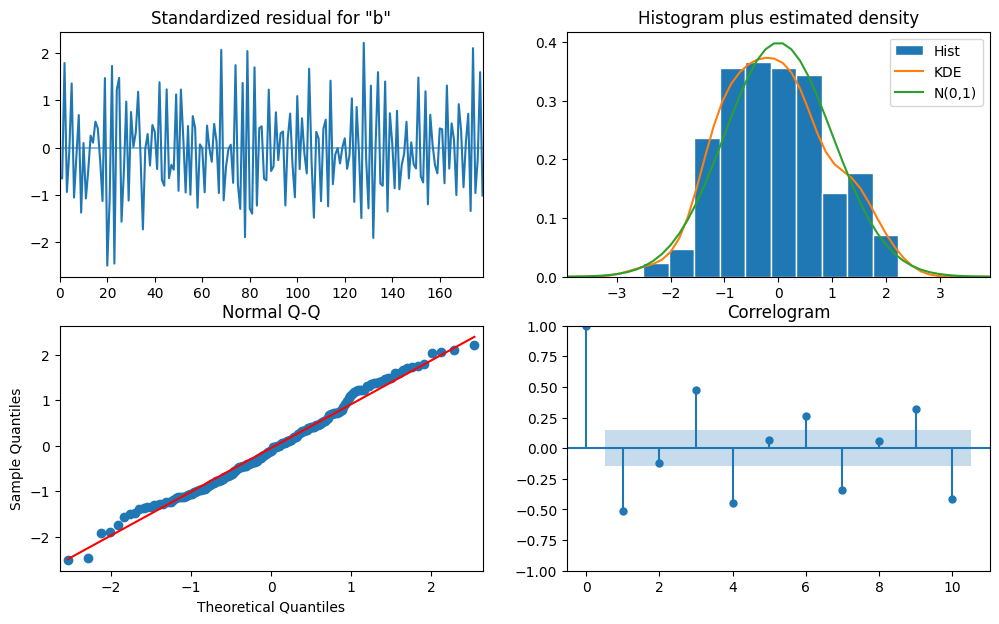

In [208]:
y = train_df[MEAT_TYPE[0]]

p, d, q = 0, 1, 0
P, D, Q, s = 1, 1, 1, 12

model = ARIMA(y,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=True,
                enforce_invertibility=True)
model_fit = model.fit()
print(model_fit.plot_diagnostics(figsize=(12, 7)))

In [209]:
forecast = model_fit.get_forecast(steps=len(test_df))
predict_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()
print(f'predict_mean: {predict_mean}, train_df: {train_df[MEAT_TYPE[0]]}')

predict_mean: 192    2.149993e+09
193    2.035184e+09
194    2.227921e+09
195    2.133527e+09
196    2.222466e+09
197    2.344499e+09
Name: predicted_mean, dtype: float64, train_df: 0      2.172000e+09
1      1.852000e+09
2      2.065000e+09
3      1.910000e+09
4      2.265000e+09
           ...     
187    2.238600e+09
188    2.153400e+09
189    2.180200e+09
190    2.215500e+09
191    2.146800e+09
Name: beef, Length: 192, dtype: float64


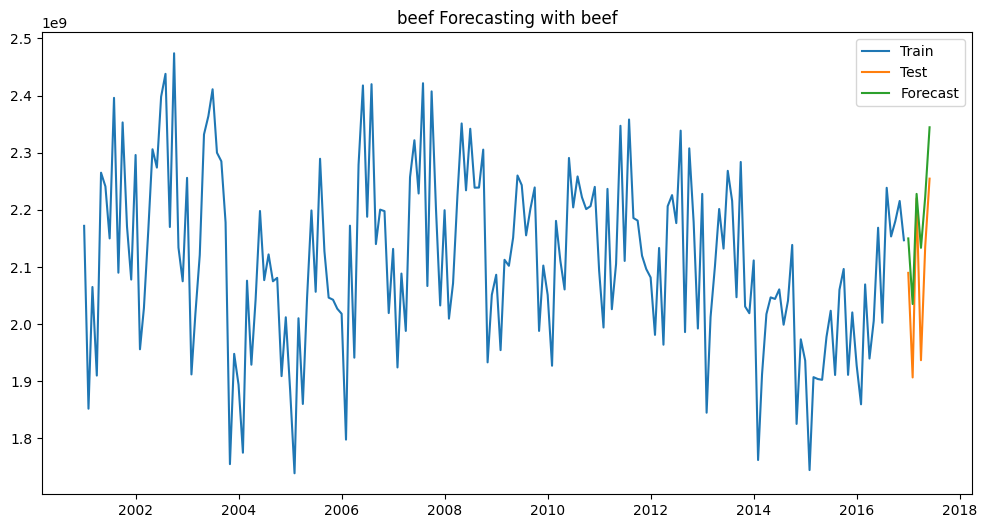

In [210]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['datetime'], train_df[MEAT_TYPE[0]], label='Train')
plt.plot(test_df['datetime'], test_df[MEAT_TYPE[0]], label='Test')
plt.plot(test_df['datetime'], predict_mean, label='Forecast')
plt.title(f'{MEAT_TYPE[0]} Forecasting with {MEAT_TYPE[0]}')
plt.legend()
plt.show()

Calculate MAE

In [211]:
mae = np.abs(test_df[MEAT_TYPE[0]] - predict_mean).mean()
mae

94965114.36454956